In [9]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
from model.unet import UNet
with open("model/config/CIFAR10_unet_config.json", "r") as f: config = json.load(f)

model = UNet(**config).to(device)

test = torch.normal(0, 1, (1, 3,32,32)).to(device)
model(test, t=5)

/home/anton/source/torch-env/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


tensor([[[[ 3.9405e-01, -1.1630e-02,  9.8185e-01,  ...,  5.0018e-01,
            3.0806e-01,  4.0809e-01],
          [ 5.0410e-01, -3.6449e-01,  3.4737e-01,  ...,  5.9847e-01,
            1.1345e-01,  7.8401e-02],
          [ 6.0034e-01,  8.0280e-01, -6.4234e-02,  ...,  1.0183e+00,
            6.0876e-01,  3.4284e-01],
          ...,
          [-1.3199e-01,  2.3556e-01,  1.9086e-01,  ...,  6.6609e-01,
            1.1668e-05, -1.2177e-01],
          [ 6.7382e-01, -7.7791e-02,  1.9551e-02,  ...,  4.6251e-01,
           -8.0633e-02,  3.9313e-01],
          [ 9.8821e-02,  3.8866e-01,  2.5022e-02,  ..., -1.9038e-01,
            7.9420e-02,  6.5190e-01]],

         [[-1.5755e-01, -1.8697e-01,  1.1823e-01,  ...,  2.8719e-01,
           -2.7283e-01,  1.2674e-01],
          [-8.1206e-02,  1.6055e-01,  1.7664e-01,  ..., -1.5004e-01,
           -4.2236e-01, -2.1668e-01],
          [-8.4569e-01,  1.9256e-01, -2.1292e-02,  ..., -4.4298e-01,
           -4.8176e-01,  2.1657e-01],
          ...,
     

In [58]:
def evaluate_as_vector(x, model, t=0):
    x = torch.reshape(x, (1,3,32,32))
    out = model(x, t=t)
    return torch.reshape(out, (3072,))

test = torch.normal(0, 1, (3072,)).to(device)

#evaluate_as_vector(test)

In [4]:
from torch.autograd.functional import jacobian

J = jacobian(evaluate_as_vector, inputs=test)

In [5]:
eig = torch.linalg.eig(J)

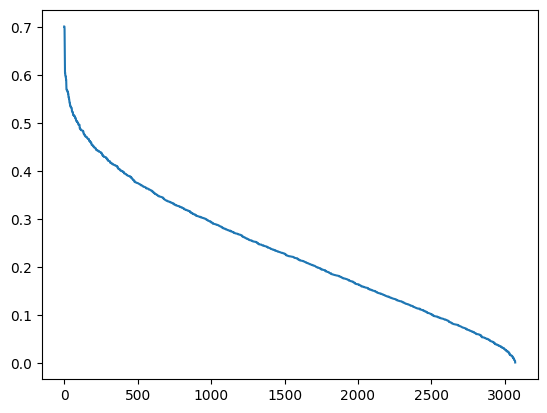

In [6]:
plt.plot(sorted(eig.eigenvalues.abs().detach().cpu().numpy(), reverse=True))

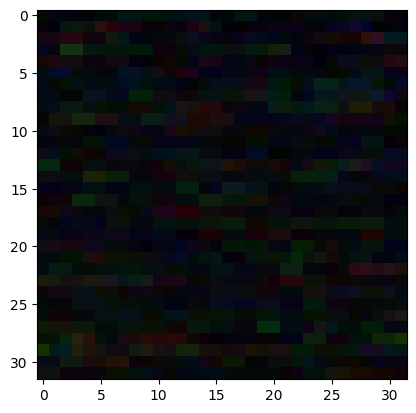

In [10]:
top_eigenvec = eig.eigenvectors[0]
top_eigenvec_image = torch.reshape(top_eigenvec, (3,32,32)).abs().detach().cpu().numpy()

top_eigenvec_image = np.moveaxis(top_eigenvec_image, 0, -1)

plt.imshow(top_eigenvec_image)

### loading a trained model

In [24]:
from model.ddpm import DDPMnet
from utils.utils import load_config

train_config = load_config("CIFAR10_train_config", "train/config")
unet_config = load_config("CIFAR10_unet_config", "model/config")
checkpoint = torch.load("out/ddpm_cifar10_2100")


ddpm = DDPMnet(unet_config, **train_config["ddpm"])

ddpm.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [50]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset_train = datasets.CIFAR10("data", train=True, download=True,
                                     transform=transforms.Compose([transforms.ToTensor()]))
training_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)

image, y = next(iter(training_data_loader))


Files already downloaded and verified


In [52]:
image

tensor([[[[0.5137, 0.5255, 0.5451,  ..., 0.8314, 0.8510, 0.8745],
          [0.5216, 0.5294, 0.5451,  ..., 0.8431, 0.8510, 0.8706],
          [0.5333, 0.5373, 0.5333,  ..., 0.8235, 0.8431, 0.8706],
          ...,
          [0.2863, 0.2863, 0.2902,  ..., 0.4000, 0.4157, 0.4275],
          [0.2745, 0.2745, 0.2784,  ..., 0.3843, 0.3922, 0.4039],
          [0.2667, 0.2667, 0.2706,  ..., 0.3686, 0.3608, 0.3686]],

         [[0.6275, 0.6392, 0.6588,  ..., 0.8667, 0.8784, 0.8941],
          [0.6353, 0.6431, 0.6588,  ..., 0.8784, 0.8824, 0.8902],
          [0.6471, 0.6510, 0.6471,  ..., 0.8667, 0.8824, 0.8980],
          ...,
          [0.4275, 0.4275, 0.4314,  ..., 0.5098, 0.5255, 0.5333],
          [0.4157, 0.4157, 0.4196,  ..., 0.4941, 0.5020, 0.5098],
          [0.4078, 0.4078, 0.4118,  ..., 0.4824, 0.4745, 0.4745]],

         [[0.6980, 0.7098, 0.7333,  ..., 0.8627, 0.8706, 0.8784],
          [0.7059, 0.7137, 0.7255,  ..., 0.8706, 0.8706, 0.8745],
          [0.7098, 0.7137, 0.7098,  ..., 0

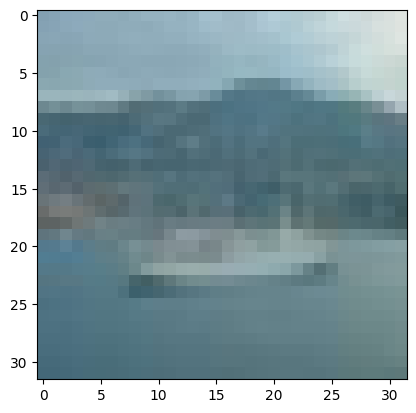

In [53]:
plt.imshow(np.moveaxis(image[0].numpy(), 0, -1))

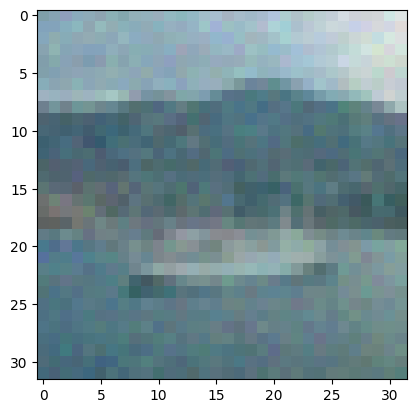

In [84]:
image = image.to(device)
noise = torch.randn((1,3,32,32)).to(device)
t = 2

image_noisy = torch.sqrt(ddpm.prod_alphas[t]) * image + torch.sqrt(1 - ddpm.prod_alphas[t]) * noise
plt.imshow(np.moveaxis(image_noisy[0].cpu().detach().numpy(), 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.121682..1.0022838].


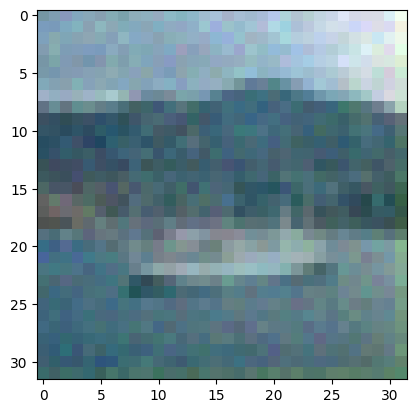

In [91]:
image_noisy = image_noisy.to(device)
ddpm = ddpm.to(device)

image_dn = ddpm.noise_net(image_noisy, t)
image_dn /= 1.71
plt.imshow(np.moveaxis(image_dn[0].cpu().detach().numpy(), 0, -1))

In [86]:
image_v = torch.reshape(image, (3072,))
image_noisy_v = torch.reshape(image_noisy, (3072,))

def evaluate_as_vector(x, t=t):
    x = torch.reshape(x, (1,3,32,32))
    out = ddpm.noise_net(x, t)
    return torch.reshape(out, (3072,))

evaluate_as_vector(image_noisy_v)

tensor([0.7887, 0.8468, 0.9148,  ..., 0.7591, 0.6887, 0.7302], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [87]:
J_trained = jacobian(evaluate_as_vector, inputs=image_noisy_v)

In [88]:
eig_trained = torch.linalg.eig(J_trained)

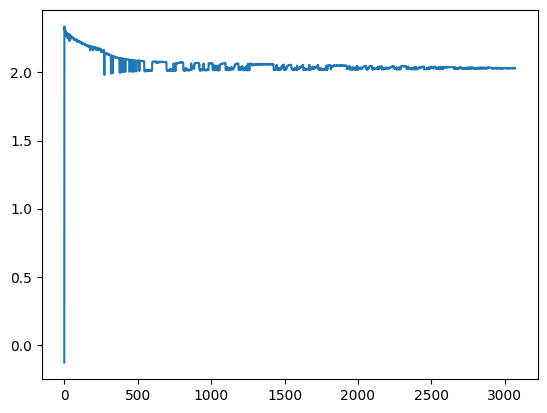

In [92]:
plt.plot(eig_trained.eigenvalues.detach().cpu().numpy())

In [93]:
eig_trained.eigenvalues

tensor([-0.1301+0.0000j,  2.3375+0.0000j,  2.3110+0.0159j,  ...,
         2.0300+0.0000j,  2.0311+0.0000j,  2.0308+0.0000j], device='cuda:0')

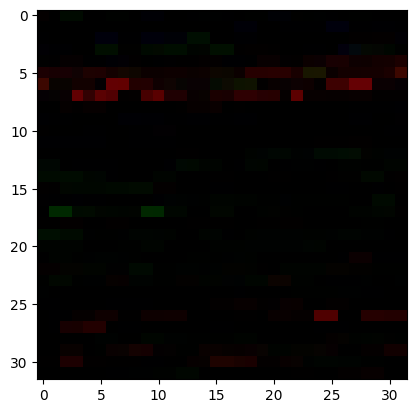

In [102]:
top_eigenvec = eig_trained.eigenvectors[1]
top_eigenvec_image = torch.reshape(top_eigenvec, (3,32,32)).abs().detach().cpu().numpy()

top_eigenvec_image = np.moveaxis(top_eigenvec_image, 0, -1)

plt.imshow(top_eigenvec_image)